<a href="https://colab.research.google.com/github/vtecftwy/fastbook/blob/master/resources/04_mnist_full_set_sgd_with_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

# Rerun Chapter 4 with the full MNIST dataset
Only the SGD part

## Load full MNIST dataset and prepare datasets

We are try to rerun the two classifiers built before to classify images as a 3 or a 7, but using the full dataset with 10 digits. So let's download the full MNIST datasets:

In [3]:
path = untar_data(URLs.MNIST)    # Full dataset (0s to 9s)

In [4]:
Path.BASE_PATH = path

We can see what's in this directory by using `ls`, a method added by fastai. This method returns an object of a special fastai class called `L`, which has all the same functionality of Python's built-in `list`, plus a lot more. One of its handy features is that, when printed, it displays the count of items, before listing the items themselves (if there are more than 10 items, it just shows the first few):

In [5]:
path.ls()

(#2) [Path('testing'),Path('training')]

The MNIST dataset follows a common layout for machine learning datasets: separate folders for the training set and the validation set (and/or test set). Note, though, that the names of both image folders have changed: `train` into `training` and `valid` into `testing`. Keep this in mind when you look for images in the code below.

Let's see what's inside the training set:

In [6]:
(path/'training').ls()

(#10) [Path('training/0'),Path('training/9'),Path('training/8'),Path('training/4'),Path('training/6'),Path('training/5'),Path('training/2'),Path('training/7'),Path('training/3'),Path('training/1')]

### Prepare training set
There's a folder for each digit from 0s to 9s. Let's take a look in one of these folders (using `sorted` to ensure we all get the same order of files). To do so, it is convenient to use a `dict`, indexed by the digit (0 -> 9). It prevents us from creating 10 different variables and from writing 10 times tvery similar code. We also could use a list of lists.
``` python
    paths_dict = {0: [list of the paths to images of 0],
                  1: [list of the paths to images of 1],

                  i: [list of the paths to images of i],

                  9: [list of the paths to images of 9],
                 }
```

In [7]:
paths_dict = {}         # Create an empty dictionary to hold the paths list for each digit
for i in range(10):
    paths_dict[i] = (path/'training'/f"{i}").ls().sorted()   # add the list of path for digit i to the dict

paths_dict

{0: (#5923) [Path('training/0/1.png'),Path('training/0/1000.png'),Path('training/0/10005.png'),Path('training/0/10010.png'),Path('training/0/10022.png'),Path('training/0/10025.png'),Path('training/0/10026.png'),Path('training/0/10045.png'),Path('training/0/10069.png'),Path('training/0/10071.png')...],
 1: (#6742) [Path('training/1/10006.png'),Path('training/1/10007.png'),Path('training/1/1002.png'),Path('training/1/10020.png'),Path('training/1/10027.png'),Path('training/1/1003.png'),Path('training/1/10040.png'),Path('training/1/10048.png'),Path('training/1/10058.png'),Path('training/1/10067.png')...],
 2: (#5958) [Path('training/2/10009.png'),Path('training/2/10016.png'),Path('training/2/10024.png'),Path('training/2/10029.png'),Path('training/2/10072.png'),Path('training/2/10073.png'),Path('training/2/10075.png'),Path('training/2/10078.png'),Path('training/2/10081.png'),Path('training/2/10082.png')...],
 3: (#6131) [Path('training/3/10.png'),Path('training/3/10000.png'),Path('training/

Let’s take a look at one image for each of the digits:

In [8]:
for i in range(10):
    img_paths = paths_dict[i][3]
    img = Image.open(img_paths)
    display(img)

Let's create a tensor containing all of the images representing a single digit, stacked together. We use the same list comprehension as in `04_mnist_basic`. But since we have 10 groups, we again use a dictionary indexed with the digit 0 to 9, to hold the stacked images, instead of 10 variables. You also can use a list of tensors here. There are also other methods that may be faster.

In [9]:
tensors_dict = {}
for i in range(10):
    tensors_dict[i] = [tensor(Image.open(o)) for o in paths_dict[i]]

In [10]:
# Show the number of images for each digit
print(f'Total number of images: {sum([len(v) for k, v in tensors_dict.items()]):,d}')
display([f"{len(v):,d} images for {k}" for k, v in tensors_dict.items()])


Total number of images: 60,000


['5,923 images for 0',
 '6,742 images for 1',
 '5,958 images for 2',
 '6,131 images for 3',
 '5,842 images for 4',
 '5,421 images for 5',
 '5,918 images for 6',
 '6,265 images for 7',
 '5,851 images for 8',
 '5,949 images for 9']

We'll also check that one of the images looks okay. Since we now have tensors (which Jupyter by default will print as values), rather than PIL images (which Jupyter by default will display as images), we need to use fastai's `show_image` function to display it:

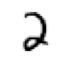

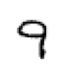

In [11]:
show_image(tensors_dict[2][1])
show_image(tensors_dict[9][1]);

Some operations in PyTorch, such as taking a mean, require us to *cast* our integer types to float types. Since we'll be needing this later, we'll also cast our stacked tensor to `float` now. Casting in PyTorch is as simple as typing the name of the type you wish to cast to, and treating it as a method.

Generally when images are floats, the pixel values are expected to be between 0 and 1, so we will also divide by 255 here:

In [12]:
# Calculate the stacked tensor for each of the digit and store that tensor in a dictionary index by digit
stacked_tensors_dict = {}
for digit, img_tensor in tensors_dict.items():
    stacked_tensors_dict[digit] = torch.stack(img_tensor).float()/255

Perhaps the most important attribute of a tensor is its *shape*. This tells you the length of each axis. In this case, we can see that we have around 6,000 images for each digit, each image of size 28×28 pixels. There is nothing specifically about this tensor that says that the first axis is the number of images, the second is the height, and the third is the width—the semantics of a tensor are entirely up to us, and how we construct it. As far as PyTorch is concerned, it is just a bunch of numbers in memory.

In [13]:
print('Shapes of image tensor for each digit:')
for digit, img_tensor in stacked_tensors_dict.items():
    print('   ', digit, ': ', stacked_tensors_dict[digit].shape)

Shapes of image tensor for each digit:
    0 :  torch.Size([5923, 28, 28])
    1 :  torch.Size([6742, 28, 28])
    2 :  torch.Size([5958, 28, 28])
    3 :  torch.Size([6131, 28, 28])
    4 :  torch.Size([5842, 28, 28])
    5 :  torch.Size([5421, 28, 28])
    6 :  torch.Size([5918, 28, 28])
    7 :  torch.Size([6265, 28, 28])
    8 :  torch.Size([5851, 28, 28])
    9 :  torch.Size([5949, 28, 28])


### Prepare validation set

In [14]:
valid_tensors_dict = {}

for digit, tnrs in stacked_tensors_dict.items():
    valid_tensors_dict[digit] = torch.stack([tensor(Image.open(o)) 
                                             for o in (path/'testing'/f"{digit}").ls()])
    valid_tensors_dict[digit] = valid_tensors_dict[digit].float()/255
    print('shape for',digit, ':', valid_tensors_dict[digit].shape)

shape for 0 : torch.Size([980, 28, 28])
shape for 1 : torch.Size([1135, 28, 28])
shape for 2 : torch.Size([1032, 28, 28])
shape for 3 : torch.Size([1010, 28, 28])
shape for 4 : torch.Size([982, 28, 28])
shape for 5 : torch.Size([892, 28, 28])
shape for 6 : torch.Size([958, 28, 28])
shape for 7 : torch.Size([1028, 28, 28])
shape for 8 : torch.Size([974, 28, 28])
shape for 9 : torch.Size([1009, 28, 28])


It's good to get in the habit of checking shapes as you go. Here we see 10 tensors, each representing one digit validation set of about 1,000 images of size 28×28. Total number of validation images is 10,000.

In [15]:
print('Shapes of image tensor for each digit:')
for digit, tnrs in valid_tensors_dict.items():
    print(' shape for',digit, ':', valid_tensors_dict[digit].shape)

Shapes of image tensor for each digit:
 shape for 0 : torch.Size([980, 28, 28])
 shape for 1 : torch.Size([1135, 28, 28])
 shape for 2 : torch.Size([1032, 28, 28])
 shape for 3 : torch.Size([1010, 28, 28])
 shape for 4 : torch.Size([982, 28, 28])
 shape for 5 : torch.Size([892, 28, 28])
 shape for 6 : torch.Size([958, 28, 28])
 shape for 7 : torch.Size([1028, 28, 28])
 shape for 8 : torch.Size([974, 28, 28])
 shape for 9 : torch.Size([1009, 28, 28])


## Stochastic Gradient Descent (SGD)

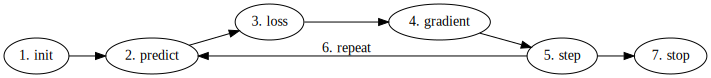

In [16]:
gv('''
"1. init"->"2. predict"->"3. loss"->"4. gradient"->"5. step"->"7. stop"
"5. step"->"2. predict"[label="6. repeat"]
''')

Steps that we are going to require, to turn a function into a machine learning classifier:

1. *Initialize* the weights.
1. For each image, use these weights to *predict* whether it appears to be a 3 or a 7.
1. Based on these predictions, calculate how good the model is (its *loss*).
1. Calculate the *gradient*, which measures for each weight, how changing that weight would change the loss
1. *Step* (that is, change) all the weights based on that calculation.
1. Go back to the step 2, and *repeat* the process.
1. Iterate until you decide to *stop* the training process (for instance, because the model is good enough or you don't want to wait any longer).

#### Prepare datasets and dataloaders

`train_x` is the set of independant variables (inputs), that is our images. We create  `train_x` tensor by concatenating all the tensors for each digit.

In [17]:
train_x = torch.cat([stacked_tensors_dict[i] for i in range(0,10)]).view(-1, 28*28)

In [18]:
train_x.shape

torch.Size([60000, 784])

As expected, it is a set of 60,000 images represented as a flat one dimension vector of shape 28 x 28 = 784

We need a label for each image, 0 to 9, depending on the digit the image represent. It is not as simple as for the basic MNIST case, as we have more than two classes and the number of images in each class is not equal. There is probably an easier way than the one below !

In [19]:
# Returns a list of 10 sublists, where each sublist consists of a as many times digit as the number of image in the category
l = [ [i] * stacked_tensors_dict[i].shape[0] for i in range(0,10)]

# check the the total number of labels is equal to the numer of images
assert sum([len(sublist) for sublist in l]) == train_x.shape[0] 

In [20]:
# Create a tensor based on the list of labels
label_list = []
for i in range(10):
    label_list.extend(l[i])
assert len(label_list) == train_x.shape[0]

train_y = torch.tensor(label_list).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([60000, 784]), torch.Size([60000, 1]))

The shapes of `train_x` and `train_y` are as expected

Attach tensors to the GPU when available

In [195]:
USE_GPU = True

In [196]:
if USE_GPU:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
else:
    device = torch.device('cpu')

print(f"Using {device}")

Using cuda


In [197]:
# Attach dataset tensors to the correct device (cpu or cuda)
train_x = train_x.to(device)
train_y = train_y.to(device)
train_x.is_cuda, train_y.is_cuda

(True, True)

A `Dataset` in PyTorch is required to return a tuple of `(x,y)` when indexed. Python provides a `zip` function which, when combined with `list`, provides a simple way to get this functionality:

In [198]:
from random import shuffle

dset = list(zip(train_x,train_y))
shuffle(dset)


x, y = dset[0]
x.shape,y

(torch.Size([784]), tensor([2], device='cuda:0'))

Now we do the same for the validation sets

In [199]:
valid_x = torch.cat([valid_tensors_dict[i] for i in range(0,10)]).view(-1, 28*28)

# Returns a list of 10 sublists, where each sublist consists of a as many times digit as the number of image in the category
l = [ [i] * valid_tensors_dict[i].shape[0] for i in range(0,10)]

# check the the total number of labels is equal to the numer of images
assert sum([len(sublist) for sublist in l]) == valid_x.shape[0] 
print(valid_x.shape)

# Create a tensor based on the list of labels
label_list = []
for i in range(10):
    label_list.extend(l[i])
assert len(label_list) == valid_x.shape[0]

valid_y = torch.tensor(label_list).unsqueeze(1)
print(valid_y.shape)

# Attach validation tensor to the correct device
valid_x = valid_x.to(device)
valid_y = valid_y.to(device)

print(valid_x.is_cuda, valid_y.is_cuda)

valid_dset = list(zip(valid_x,valid_y))

torch.Size([10000, 784])
torch.Size([10000, 1])
True True


Datasets are ready. Now we prepare the dataloaders to feed the training loop.

In [200]:
dl = DataLoader(dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=256)

#### Define the model architecture and parameters

Model is defined by creating functions to compute each of the 7 steps listed above

##### Parameters

In our model, we need to evaluate the distance from one image (input) to each of the possible classes (0 - 9). So we need to predict 10 values, out of which we will pick the minimum value to predict the correpsonding digit.

In effect,**y** in **y=Wx+b** represents the `distances` between the image **x** and each of the digits. **y** is therefore a vector of shape `(10)`. The prediction is computed from an image **x** which is a vector of shape `(784)`. Therefore **W** must be of shape `(784, 10)`. And **b** must be of the same shape as the output, that is shape `(10)`.

<img src="https://raw.githubusercontent.com/vtecftwy/fastbook/master/images/img_mnist_full_linear_layer.png" height="400px" />


Define a function to create random parameters, and then create **W** and **b** with the correct shapes

In [201]:
def init_params(size, std=1): 
    ps = (torch.randn(size)*std)
    ps = ps.to(device)
    ps.requires_grad = True
    return ps

weights = init_params((28*28, 10))
bias = init_params(10)

weights.shape, bias.shape, weights.device, weights.requires_grad, weights.is_leaf

(torch.Size([784, 10]),
 torch.Size([10]),
 device(type='cuda', index=0),
 True,
 True)

##### Define functions to calculate the predictions

In [202]:
def linear(xb):
    outputs =  xb @ weights + bias
    probs = torch.log_softmax(outputs, dim=1)
    return probs

def classifier(xb):
    probs = linear(xb)
    return probs.argmax(dim=1).unsqueeze(dim=1)

##### Define a function to calculate the loss

In [186]:
loss_fct = F.nll_loss

##### Define a function to calculate the gradients

In [187]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = loss_fct(preds, yb.squeeze())
    loss.backward()

In [188]:
# xb, yb = first(dl)
# # display(xb.shape, yb.shape)
# display(xb.device, weights.device, bias.device)
# probs = linear(xb)
# display(probs.shape)
# classifier(xb)
# # display(yb)
# loss_fct(probs, yb.squeeze())
# calc_grad(xb, yb, linear)
# bias.grad

##### Define a function performing one step/one epoch

In [189]:
def train_epoch(model, lr, params):
    for i, (xb, yb) in enumerate(dl):
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad * lr
            p.grad.zero_()

##### Define a function to evaluate the validation accurary

In [190]:
def accuracy_epoch(x, y):
    preds = classifier(x.to(device))
    accuracy = torch.eq(preds, y.to(device)).sum() / preds.shape[0]
    return accuracy.item()

#### Bringing it all together and run training loop

In [203]:
# Initialize the model
weights = init_params((28*28, 10))
bias = init_params(10)

lr = 1
params = weights, bias

In [204]:
# Run one period and evaluate the performance
train_epoch(linear, lr, params)
accuracy_epoch(valid_x, valid_y)

0.8481000065803528

In [205]:
%%time
n_epochs = 10
for i in range(n_epochs):
    train_epoch(linear, lr, params)
    print(f"{i}:{accuracy_epoch(valid_x, valid_y):1.4f}", end=' ')
print('\n')

0:0.8693 1:0.8796 2:0.8852 3:0.8879 4:0.8903 5:0.8925 6:0.8966 7:0.8990 8:0.8999 9:0.9013 

CPU times: user 3.19 s, sys: 90.9 ms, total: 3.28 s
Wall time: 3.29 s


In [206]:
n_epochs = 10
for i in range(n_epochs):
    train_epoch(linear, lr, params)
    print(f"{i}:{accuracy_epoch(valid_x, valid_y):1.4f}", end=' ')

0:0.9023 1:0.9035 2:0.9035 3:0.9038 4:0.9045 5:0.9053 6:0.9056 7:0.9061 8:0.9059 9:0.9066 

In [207]:
n_epochs = 10
for i in range(n_epochs):
    train_epoch(linear, lr, params)
    print(f"{i}:{accuracy_epoch(valid_x, valid_y):1.4f}", end=' ')

0:0.9069 1:0.9075 2:0.9078 3:0.9082 4:0.9085 5:0.9086 6:0.9088 7:0.9091 8:0.9099 9:0.9102 

In [208]:
%%time
n_epochs = 100
for i in range(n_epochs):
    train_epoch(linear, lr, params)
    if i%10 == 0:
        print(f"{i}:{accuracy_epoch(valid_x, valid_y):1.4f}", end=' ')
print('\n', accuracy_epoch(valid_x, valid_y))

0:0.9110 10:0.9129 20:0.9130 30:0.9146 40:0.9161 50:0.9161 60:0.9161 70:0.9166 80:0.9168 90:0.9168 
 0.9167999625205994
CPU times: user 31.4 s, sys: 824 ms, total: 32.2 s
Wall time: 32 s


In [209]:
n_epochs = 100
for i in range(n_epochs):
    train_epoch(linear, lr, params)
    if i%10 == 0:
        print(f"{i}:{accuracy_epoch(valid_x, valid_y):1.4f}", end=' ')
print('\n', accuracy_epoch(valid_x, valid_y))

0:0.9169 10:0.9170 20:0.9172 30:0.9172 40:0.9180 50:0.9181 60:0.9186 70:0.9188 80:0.9187 90:0.9187 
 0.9182999730110168


In [172]:
# %%time
# n_epochs = 1000
# for i in range(n_epochs):
#     train_epoch(linear, lr, params)
#     if i%100 == 0:
#         print(f"{i}:{accuracy_epoch(valid_x, valid_y):1.4f}", end=' ')
# print('\n', accuracy_epoch(valid_x, valid_y))

In [210]:
print(accuracy_epoch(valid_x, valid_y))

0.9182999730110168


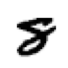

tensor([[8]], device='cuda:0')

In [174]:
img = valid_tensors_dict[8][49]
show_image(img)
plt.show()
classifier(img.view(28*28).unsqueeze(dim=0).to(device))

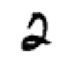

tensor([[2]], device='cuda:0')

In [175]:
img = valid_tensors_dict[2][159]
show_image(img)
plt.show()
classifier(img.view(28*28).unsqueeze(dim=0).to(device))

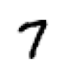

tensor([[7]], device='cuda:0')

In [176]:
img = valid_tensors_dict[7][957]
show_image(img)
plt.show()
classifier(img.view(28*28).unsqueeze(dim=0).to(device))

### Comparison CPU and GPU

When run with the GPU:
- 10 epochs:
```  python
%%time
n_epochs = 10
for i in range(n_epochs):
    train_epoch(linear, lr, params)
    print(f"{i}:{accuracy_epoch(valid_x, valid_y):1.4f}", end=' ')
print('\n')
```
```
CPU times: user 3.25 s, sys: 95.1 ms, total: 3.35 s
Wall time: 3.37 s
```
- 100 epochs:
``` python
%%time
n_epochs = 100
for i in range(n_epochs):
    train_epoch(linear, lr, params)
    if i%10 == 0:
        print(f"{i}:{accuracy_epoch(valid_x, valid_y):1.4f}", end=' ')
print('\n', accuracy_epoch(valid_x, valid_y))
```
```
CPU times: user 31.3 s, sys: 814 ms, total: 32.2 s
Wall time: 32 s
```

When run with the CPU:
- 10 epochs:
```  python
%%time
n_epochs = 10
for i in range(n_epochs):
    train_epoch(linear, lr, params)
    print(f"{i}:{accuracy_epoch(valid_x, valid_y):1.4f}", end=' ')
print('\n')
```
```
CPU times: user 3.98 s, sys: 49.5 ms, total: 4.03 s
Wall time: 4.03 s
```
- 100 epochs:
``` python
%%time
n_epochs = 100
for i in range(n_epochs):
    train_epoch(linear, lr, params)
    if i%10 == 0:
        print(f"{i}:{accuracy_epoch(valid_x, valid_y):1.4f}", end=' ')
print('\n', accuracy_epoch(valid_x, valid_y))
```
```
CPU times: user 38 s, sys: 321 ms, total: 38.3 s
Wall time: 38.2 s
```

Conclusion: the GPU is faster but not very much because the model is very simple and i/o operations are taking a large time relatively to the computation itself.

## Improve model by introducing ReLu and two layers

In [138]:
w1 = init_params((28*28, 100))
b1 = init_params(100)

w2 = init_params((100, 10))
b2 = init_params(10)

w1.shape, b1.shape, w2.shape, b2.shape

(torch.Size([784, 100]),
 torch.Size([100]),
 torch.Size([100, 10]),
 torch.Size([10]))

##### Define functions to calculate the predictions

In [139]:
activ1 = nn.ReLU()

def linear1(xb):
    outputs =  xb @ w1 + b1
    return activ1(outputs)

def linear2(xb):
    outputs =  xb @ w2 + b2
    probs = torch.log_softmax(outputs, dim=1)
    return probs

def model(xb):
    xb = linear1(xb)
    xb = linear2(xb)
    return xb

def classifier(xb):
    xb = model(xb)
    return xb.argmax(dim=1).unsqueeze(dim=1)

In [140]:
# # Testing layer by layer
# xb, yb = first(dl)
# display(xb.shape, yb.shape)
# display(linear1(xb).shape)
# display(linear2(linear1(xb)).shape)
# display(model(xb))
# classifier(xb)[0:3]

##### Define a function to calculate the loss

In [141]:
loss_fct = F.nll_loss

##### Define a function to calculate the gradients

In [142]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = loss_fct(preds, yb.squeeze())
    # print(loss)
    loss.backward()

In [143]:
# # Testing function
# xb, yb = first(dl)
# display(xb.shape, yb.shape)
# probs = model(xb)
# display(probs.shape)
# # display(yb)
# loss_fct(probs, yb.squeeze())
# calc_grad(xb, yb, model)

##### Define a function performing one step/one epoch

In [144]:
def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad * lr
            p.grad.zero_()

##### Define a function to evaluate the validation accurary

In [145]:
def accuracy_epoch(x, y):
    preds = classifier(x.to(device))
    accuracy = torch.eq(preds, y.to(device)).sum() / preds.shape[0]
    return accuracy.item()

#### Bringing it all together and run training loop

Create a function to run `n` epochs and display results.

In [146]:
from math import log10

def run_n_epochs(model, lr, params, n_epochs):
    trigger = 10**(int(log10(n_epochs))-1)
    cols = 10
    starting_i = metric_results['epochs'][-1] + 1
    for i in range(starting_i, starting_i + n_epochs):
        train_epoch(model, lr, params)
        if i%trigger == 0:
            v = accuracy_epoch(valid_x, valid_y)

            metric_results['epochs'].append(i)
            metric_results['values'].append(v)
            
            end_str = '\n' if i//trigger%cols == 0 else ' ' 
            print(f"{i:3d}:{v:1.4f}", end=end_str)
    print(f"\nLast:{v:1.4f}")
    fig, ax = plt.subplots(1, 1, figsize=(12,4))
    ax.scatter(metric_results['epochs'][1:], metric_results['values'][1:])
    return metric_results

Shuffle data, initalize parameters, run one epoch

In [147]:
shuffle(dset)
dl = DataLoader(dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=5)

w1 = init_params((28*28, 100))
b1 = init_params(100)
w2 = init_params((100, 10))
b2 = init_params(10)

lr = 1
params = w1, b1, w2, b2

metric_results = {}
metric_results['epochs'] = [0]
metric_results['values'] = [0]

train_epoch(model, lr, params)
accuracy_epoch(valid_x, valid_y)

0.7558000087738037

  1:0.7796   2:0.8210   3:0.8416   4:0.8567   5:0.8636   6:0.8736   7:0.8844   8:0.8909   9:0.8958  10:0.8994
 11:0.9022  12:0.9054  13:0.9079  14:0.9113  15:0.9123  16:0.9135  17:0.9150  18:0.9162  19:0.9155  20:0.9174

Last:0.9174
CPU times: user 7.5 s, sys: 200 ms, total: 7.7 s
Wall time: 7.71 s


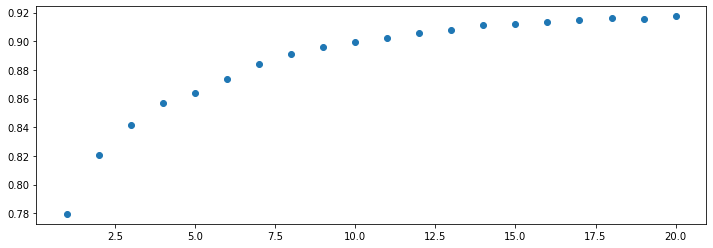

In [148]:
%%time
metric_results = run_n_epochs(model, lr, params, 20)

 21:0.9178  22:0.9198  23:0.9219  24:0.9216  25:0.9238  26:0.9233  27:0.9252  28:0.9242  29:0.9265  30:0.9271
 31:0.9287  32:0.9284  33:0.9304  34:0.9296  35:0.9301  36:0.9325  37:0.9318  38:0.9334  39:0.9355  40:0.9351

Last:0.9351


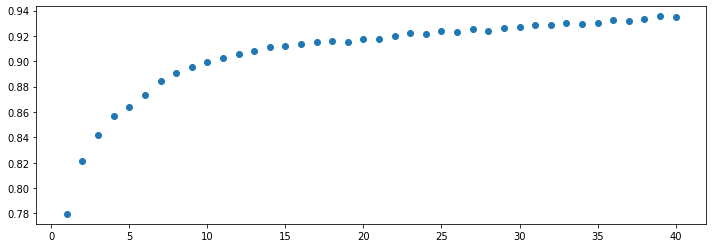

In [149]:
metric_results = run_n_epochs(model, lr, params, 20)

 41:0.9361  42:0.9364  43:0.9367  44:0.9383  45:0.9381  46:0.9396  47:0.9389  48:0.9407  49:0.9407  50:0.9397
 51:0.9414  52:0.9419  53:0.9412  54:0.9427  55:0.9431  56:0.9440  57:0.9443  58:0.9437  59:0.9449  60:0.9448

Last:0.9448


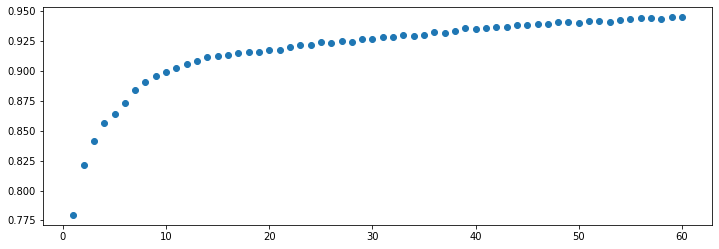

In [150]:
metric_results = run_n_epochs(model, lr, params, 20)

 61:0.9448  62:0.9448  63:0.9453  64:0.9452  65:0.9458  66:0.9457  67:0.9455  68:0.9464  69:0.9465  70:0.9465
 71:0.9467  72:0.9467  73:0.9462  74:0.9472  75:0.9465  76:0.9465  77:0.9467  78:0.9469  79:0.9468  80:0.9469
 81:0.9468  82:0.9469  83:0.9469  84:0.9471  85:0.9472  86:0.9474  87:0.9472  88:0.9470  89:0.9474  90:0.9475
 91:0.9470  92:0.9475  93:0.9475  94:0.9475  95:0.9475  96:0.9478  97:0.9473  98:0.9476  99:0.9474 100:0.9474
101:0.9480 102:0.9476 103:0.9482 104:0.9481 105:0.9482 106:0.9479 107:0.9486 108:0.9483 109:0.9482 110:0.9485

Last:0.9485


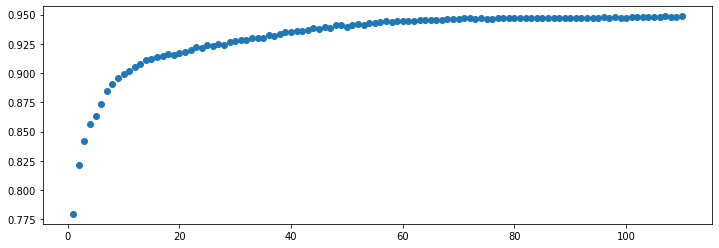

In [151]:
metric_results = run_n_epochs(model, lr, params, 50)

111:0.9489 112:0.9481 113:0.9486 114:0.9482 115:0.9485 116:0.9481 117:0.9487 118:0.9488 119:0.9484 120:0.9485
121:0.9484 122:0.9477 123:0.9482 124:0.9481 125:0.9481 126:0.9484 127:0.9485 128:0.9484 129:0.9486 130:0.9487
131:0.9484 132:0.9492 133:0.9489 134:0.9490 135:0.9491 136:0.9487 137:0.9489 138:0.9490 139:0.9487 140:0.9487
141:0.9495 142:0.9492 143:0.9489 144:0.9492 145:0.9495 146:0.9494 147:0.9493 148:0.9494 149:0.9499 150:0.9495
151:0.9494 152:0.9494 153:0.9491 154:0.9487 155:0.9489 156:0.9488 157:0.9494 158:0.9490 159:0.9491 160:0.9490

Last:0.9490


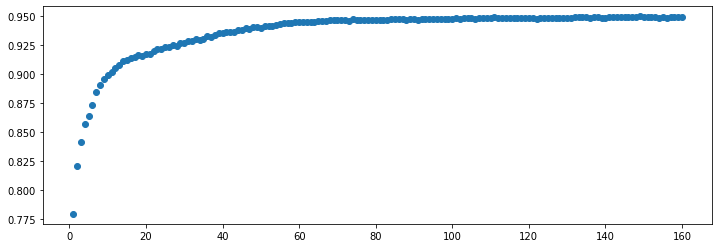

In [152]:
metric_results = run_n_epochs(model, lr, params, 50)

170:0.9494 180:0.9498 190:0.9492 200:0.9490
210:0.9492 220:0.9494 230:0.9494 240:0.9496 250:0.9493 260:0.9495 
Last:0.9495
CPU times: user 36 s, sys: 915 ms, total: 37 s
Wall time: 36.7 s


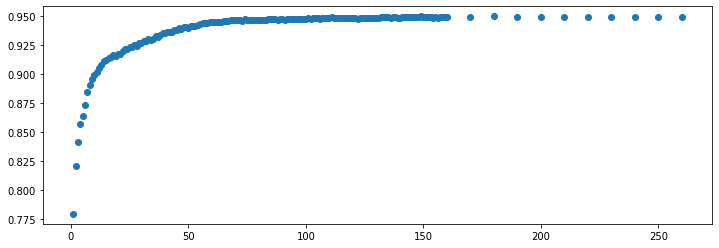

In [153]:
%%time
metric_results = run_n_epochs(model, lr/2, params, 100)

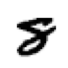

tensor([[8]], device='cuda:0')

In [154]:
img = valid_tensors_dict[8][49]
show_image(img)
plt.show()
classifier(img.view(28*28).unsqueeze(dim=0).to(device))

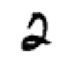

tensor([[2]], device='cuda:0')

In [155]:
img = valid_tensors_dict[2][159]
show_image(img)
plt.show()

classifier(img.view(28*28).unsqueeze(dim=0).to(device))

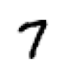

tensor([[7]], device='cuda:0')

In [156]:
img = valid_tensors_dict[7][957]
show_image(img)
plt.show()

classifier(img.view(28*28).unsqueeze(dim=0).to(device))

## Improvement 2 model by introducing ReLu and three layers

In [110]:
w1 = init_params((28*28, 150))
b1 = init_params(150)

w2 = init_params((150, 75))
b2 = init_params(75)

w3 = init_params((75, 10))
b3 = init_params(10)

w1.shape, b1.shape, w2.shape, b2.shape, w3.shape, b3.shape, w1.is_cuda, w3.is_cuda

(torch.Size([784, 150]),
 torch.Size([150]),
 torch.Size([150, 75]),
 torch.Size([75]),
 torch.Size([75, 10]),
 torch.Size([10]),
 True,
 True)

##### Define functions to calculate the predictions

In [111]:
activ2 = nn.ReLU()

def linear1(xb):
    outputs =  xb @ w1 + b1
    return activ2(outputs)

def linear2(xb):
    outputs =  xb @ w2 + b2
    return activ2(outputs)

def linear3(xb):
    """https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.log_softmax"""
    outputs =  xb @ w3 + b3
    probs = torch.log_softmax(outputs, dim=1)
    return probs

def model(xb):
    xb = linear1(xb)
    xb = linear2(xb)
    xb = linear3(xb)
    return xb

def classifier(xb):
    xb = model(xb)
    return xb.argmax(dim=1).unsqueeze(dim=1)

In [112]:
# # Testing layer by layer
# xb, yb = first(dl)
# display(xb.shape, yb.shape)
# display(linear1(xb).shape)
# display(linear2(linear1(xb)).shape)
# display(linear3(linear2(linear1(xb))).shape)
# display(model(xb))
# classifier(xb)[0:3]

##### Define a function to calculate the loss

In [113]:
loss_fct = F.nll_loss

##### Define a function to calculate the gradients

In [114]:
def calc_grad(xb, yb, model):
    probs = model(xb)
    loss = loss_fct(probs, yb.squeeze())
    loss.backward()
    return loss

In [115]:
# # Testing function
# xb, yb = first(dl)
# display(xb.shape, yb.shape)
# probs = model(xb)
# display(probs.shape)
# # display(yb)
# loss_fct(probs, yb.squeeze())
# calc_grad(xb, yb, model)

##### Define a function performing one step/one epoch

In [116]:
def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            # print(f"Sum of grads: {p.grad.sum().item()}")
            p.data -= p.grad * lr
            p.grad.zero_()

##### Define a function to evaluate the validation accurary

In [120]:
def accuracy_epoch(x, y):
    preds = classifier(x.to(device))
    accuracy = torch.eq(preds, y.to(device)).sum() / preds.shape[0]
    return accuracy.item()

#### Bringing it all together and run training loop

Create a function to run `n` epochs and display results.

In [118]:
from math import log10

def run_n_epochs(model, lr, params, n_epochs):
    trigger = 10**(int(log10(n_epochs))-1)
    cols = 10
    starting_i = metric_results['epochs'][-1] + 1
    
    for i in range(starting_i, starting_i + n_epochs):
        train_epoch(model, lr, params)
        if i%trigger == 0:
            v = accuracy_epoch(valid_x, valid_y)

            metric_results['epochs'].append(i)
            metric_results['values'].append(v)
            
            end_str = '\n' if i//trigger%cols == 0 else ' ' 
            print(f"{i:3d}:{v:1.4f}", end=end_str)
    
    print(f"\nLast:{v:1.4f}")
    
    fig, ax = plt.subplots(1, 1, figsize=(12,4))
    ax.scatter(metric_results['epochs'][1:], metric_results['values'][1:])

    return metric_results

Shuffle data, initalize parameters, run one epoch

In [121]:
shuffle(dset)
dl = DataLoader(dset, batch_size=128)
valid_dl = DataLoader(valid_dset, batch_size=128)

w1 = init_params((28*28, 150))
b1 = init_params(150)
w2 = init_params((150, 50))
b2 = init_params(50)
w3 = init_params((50, 10))
b3 = init_params(10)

# display(w1.shape, b1.shape, w1.is_cuda, w2.shape, b2.shape, w2.is_cuda, w3.shape, b3.shape, w3.is_cuda)

lr = 0.1
params = w1, b1, w2, b2, w3, b3

metric_results = {}
metric_results['epochs'] = [0]
metric_results['values'] = [0]

train_epoch(model, lr, params)
accuracy_epoch(valid_x, valid_y)

0.26809999346733093

  1:0.3341   2:0.3509   3:0.3581   4:0.3825   5:0.4283   6:0.4346   7:0.4478   8:0.4541   9:0.4780  10:0.4659
 11:0.4871  12:0.4946  13:0.5285  14:0.5618  15:0.5694  16:0.5949  17:0.6029  18:0.6106  19:0.6178  20:0.6301

Last:0.6301
CPU times: user 12.6 s, sys: 315 ms, total: 13 s
Wall time: 12.9 s


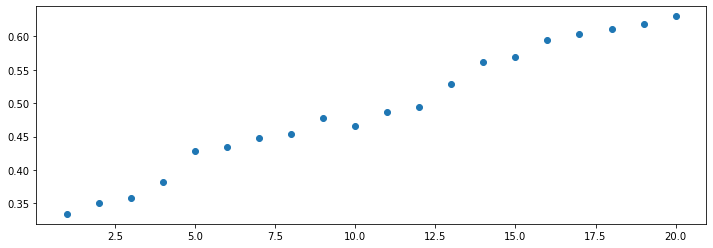

In [122]:
%%time
metric_results = run_n_epochs(model, lr, params, 20)

 21:0.6263  22:0.6394  23:0.6399  24:0.6424  25:0.6493  26:0.6500  27:0.6611  28:0.6540  29:0.6569  30:0.6573
 31:0.6728  32:0.7042  33:0.6984  34:0.7100  35:0.7261  36:0.7339  37:0.7394  38:0.7428  39:0.7471  40:0.7442

Last:0.7442


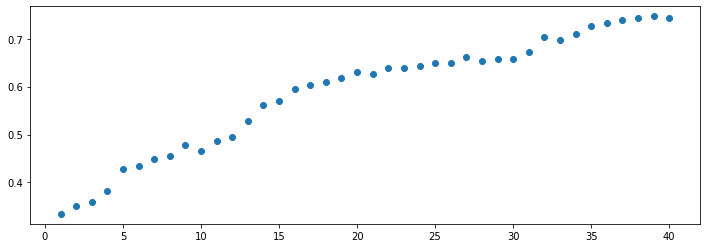

In [123]:
metric_results = run_n_epochs(model, lr, params, 20)

 41:0.7513  42:0.7542  43:0.7570  44:0.7385  45:0.7638  46:0.7910  47:0.7658  48:0.7675  49:0.7189  50:0.7762
 51:0.7720  52:0.7982  53:0.7516  54:0.8096  55:0.7361  56:0.8247  57:0.8529  58:0.8266  59:0.8655  60:0.8775
 61:0.8790  62:0.8857  63:0.8891  64:0.8923  65:0.8925  66:0.8951  67:0.8799  68:0.9004  69:0.9027  70:0.9025
 71:0.9026  72:0.9082  73:0.9076  74:0.9089  75:0.9113  76:0.9110  77:0.9117  78:0.9129  79:0.9147  80:0.9160
 81:0.9174  82:0.9182  83:0.9192  84:0.9199  85:0.9208  86:0.9214  87:0.9220  88:0.9234  89:0.9244  90:0.9248

Last:0.9248


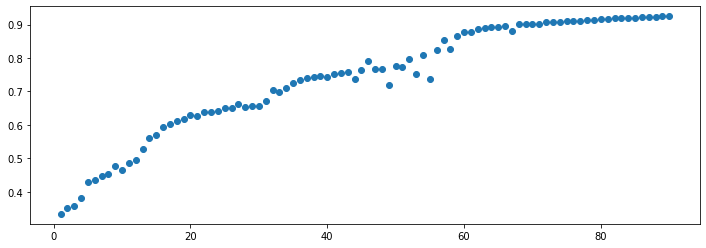

In [124]:
metric_results = run_n_epochs(model, lr, params, 50)

 91:0.9291  92:0.9294  93:0.9299  94:0.9298  95:0.9300  96:0.9302  97:0.9301  98:0.9311  99:0.9314 100:0.9318
101:0.9324 102:0.9324 103:0.9324 104:0.9326 105:0.9325 106:0.9328 107:0.9331 108:0.9329 109:0.9332 110:0.9335

Last:0.9335


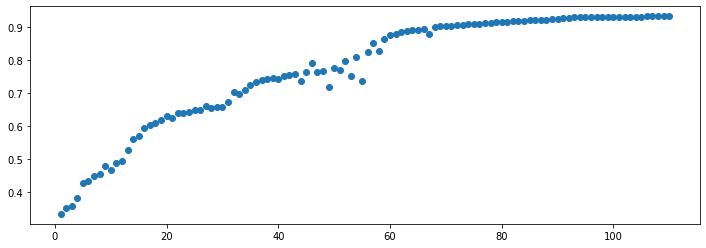

In [125]:
metric_results = run_n_epochs(model, lr/2, params, 20)

111:0.9353 112:0.9357 113:0.9355 114:0.9357 115:0.9362 116:0.9360 117:0.9363 118:0.9366 119:0.9368 120:0.9370
121:0.9372 122:0.9373 123:0.9376 124:0.9377 125:0.9376 126:0.9376 127:0.9378 128:0.9378 129:0.9379 130:0.9381

Last:0.9381


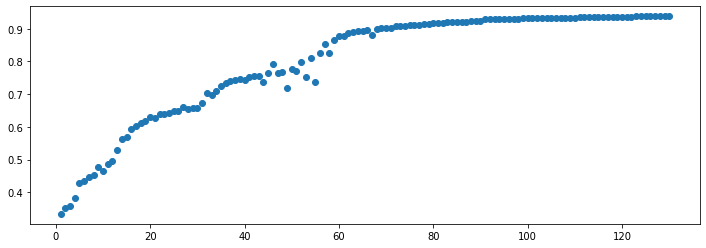

In [126]:
metric_results = run_n_epochs(model, lr/4, params, 20)

131:0.9387 132:0.9390 133:0.9388 134:0.9389 135:0.9389 136:0.9389 137:0.9389 138:0.9387 139:0.9385 140:0.9386
141:0.9387 142:0.9388 143:0.9387 144:0.9389 145:0.9388 146:0.9387 147:0.9387 148:0.9387 149:0.9388 150:0.9391

Last:0.9391


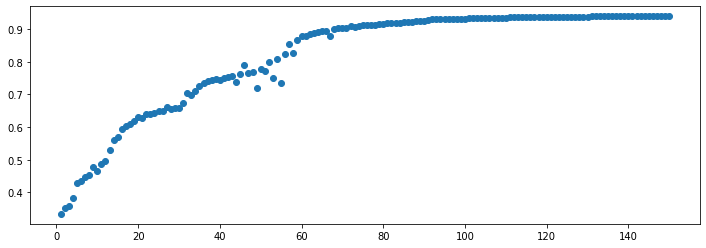

In [127]:
metric_results = run_n_epochs(model, lr/8, params, 20)

151:0.9391 152:0.9392 153:0.9393 154:0.9395 155:0.9396 156:0.9397 157:0.9398 158:0.9398 159:0.9397 160:0.9397
161:0.9397 162:0.9397 163:0.9397 164:0.9396 165:0.9397 166:0.9397 167:0.9397 168:0.9397 169:0.9397 170:0.9397

Last:0.9397


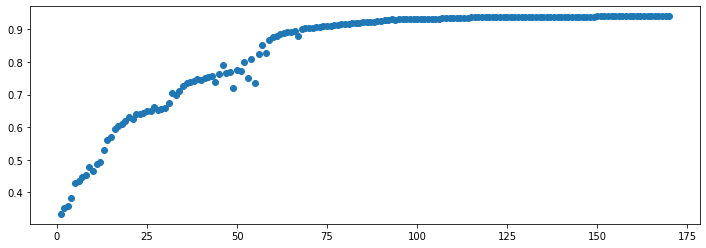

In [128]:
metric_results = run_n_epochs(model, lr/8, params, 20)

171:0.9401 172:0.9402 173:0.9402 174:0.9403 175:0.9402 176:0.9402 177:0.9400 178:0.9401 179:0.9400 180:0.9400
181:0.9401 182:0.9401 183:0.9401 184:0.9402 185:0.9402 186:0.9402 187:0.9402 188:0.9402 189:0.9402 190:0.9402

Last:0.9402


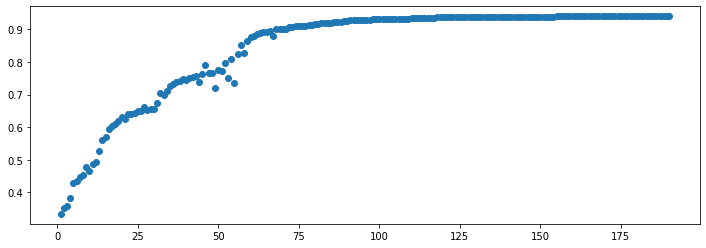

In [129]:
metric_results = run_n_epochs(model, lr/16, params, 20)

191:0.9400 192:0.9399 193:0.9400 194:0.9400 195:0.9400 196:0.9400 197:0.9400 198:0.9400 199:0.9400 200:0.9400
201:0.9400 202:0.9401 203:0.9402 204:0.9401 205:0.9401 206:0.9401 207:0.9401 208:0.9401 209:0.9401 210:0.9401
211:0.9401 212:0.9402 213:0.9402 214:0.9402 215:0.9401 216:0.9403 217:0.9402 218:0.9402 219:0.9402 220:0.9402
221:0.9405 222:0.9402 223:0.9404 224:0.9406 225:0.9406 226:0.9406 227:0.9405 228:0.9405 229:0.9405 230:0.9406
231:0.9406 232:0.9406 233:0.9406 234:0.9405 235:0.9405 236:0.9405 237:0.9406 238:0.9407 239:0.9407 240:0.9407

Last:0.9407


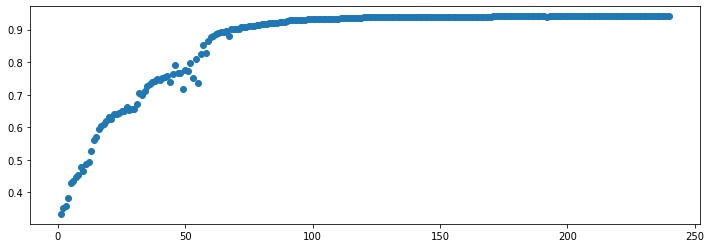

In [130]:
metric_results = run_n_epochs(model, lr/32, params, 50)

In [133]:
# %%time
# metric_results = run_n_epochs(model, lr/64, params, 200)

In [134]:
# %%time
# metric_results = run_n_epochs(model, lr/32, params, 500)

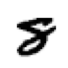

tensor([[8]], device='cuda:0')

In [135]:
img = valid_tensors_dict[8][49]
show_image(img)
plt.show()
classifier(img.view(28*28).unsqueeze(dim=0).to(device))

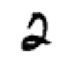

tensor([[2]], device='cuda:0')

In [136]:
img = valid_tensors_dict[2][159]
show_image(img)
plt.show()

classifier(img.view(28*28).unsqueeze(dim=0).to(device))

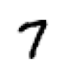

tensor([[7]], device='cuda:0')

In [137]:
img = valid_tensors_dict[7][957]
show_image(img)
plt.show()

classifier(img.view(28*28).unsqueeze(dim=0).to(device))

## Attach dataset to GPU with DataBlock

Will use the 2 layer model above but will attach the datasets to the GPU at DataBlock level

##### Define functions to calculate the predictions

In [89]:
activ1 = nn.ReLU()

def linear1(xb):
    outputs =  xb @ w1 + b1
    return activ1(outputs)

def linear2(xb):
    outputs =  xb @ w2 + b2
    probs = torch.log_softmax(outputs, dim=1)
    return probs

def model(xb):
    xb = linear1(xb)
    xb = linear2(xb)
    return xb

def classifier(xb):
    xb = model(xb)
    return xb.argmax(dim=1).unsqueeze(dim=1)

##### Define a function to calculate the loss

In [90]:
loss_fct = F.nll_loss

##### Define a function to calculate the gradients

In [91]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = loss_fct(preds, yb.squeeze())
    # print(loss)
    loss.backward()

##### Define a function performing one step/one epoch

In [92]:
def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad * lr
            p.grad.zero_()

##### Define a function to evaluate the validation accurary

In [93]:
def accuracy_epoch(x, y):
    preds = classifier(x.to(device))
    accuracy = torch.eq(preds, y.to(device)).sum() / preds.shape[0]
    return accuracy.item()

#### Bringing it all together and run training loop

Create a function to run `n` epochs and display results.

In [94]:
from math import log10

def run_n_epochs(model, lr, params, n_epochs):
    trigger = 10**(int(log10(n_epochs))-1)
    cols = 10
    starting_i = metric_results['epochs'][-1] + 1
    for i in range(starting_i, starting_i + n_epochs):
        train_epoch(model, lr, params)
        if i%trigger == 0:
            v = accuracy_epoch(valid_x, valid_y)

            metric_results['epochs'].append(i)
            metric_results['values'].append(v)
            
            end_str = '\n' if i//trigger%cols == 0 else ' ' 
            print(f"{i:3d}:{v:1.4f}", end=end_str)
    print(f"\nLast:{v:1.4f}")
    fig, ax = plt.subplots(1, 1, figsize=(12,4))
    ax.scatter(metric_results['epochs'][1:], metric_results['values'][1:])
    return metric_results

##### Prepare datasets and dataloaders

`train_x` is the set of independant variables (inputs), that is our images. We create  `train_x` tensor by concatenating all the tensors for each digit.

In [95]:
train_x = torch.cat([stacked_tensors_dict[i] for i in range(0,10)]).view(-1, 28*28)

In [96]:
train_x.shape

torch.Size([60000, 784])

As expected, it is a set of 60,000 images represented as a flat one dimension vector of shape 28 x 28 = 784

We need a label for each image, 0 to 9, depending on the digit the image represent. It is not as simple as for the basic MNIST case, as we have more than two classes and the number of images in each class is not equal. There is probably an easier way than the one below !

In [97]:
# Returns a list of 10 sublists, where each sublist consists of a as many times digit as the number of image in the category
l = [ [i] * stacked_tensors_dict[i].shape[0] for i in range(0,10)]

# check the the total number of labels is equal to the numer of images
assert sum([len(sublist) for sublist in l]) == train_x.shape[0] 

In [98]:
# Create a tensor based on the list of labels
label_list = []
for i in range(10):
    label_list.extend(l[i])
assert len(label_list) == train_x.shape[0]

train_y = torch.tensor(label_list).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([60000, 784]), torch.Size([60000, 1]))

The shapes of `train_x` and `train_y` are as expected

Now we do the same for the validation sets

In [99]:
valid_x = torch.cat([valid_tensors_dict[i] for i in range(0,10)]).view(-1, 28*28)

# Returns a list of 10 sublists, where each sublist consists of a as many times digit as the number of image in the category
l = [ [i] * valid_tensors_dict[i].shape[0] for i in range(0,10)]

# check the the total number of labels is equal to the numer of images
assert sum([len(sublist) for sublist in l]) == valid_x.shape[0] 
print(valid_x.shape)

# Create a tensor based on the list of labels
label_list = []
for i in range(10):
    label_list.extend(l[i])
assert len(label_list) == valid_x.shape[0]

valid_y = torch.tensor(label_list).unsqueeze(1)
print(valid_y.shape)

valid_dset = list(zip(valid_x,valid_y))

torch.Size([10000, 784])
torch.Size([10000, 1])


Datasets are ready. Now we prepare the dataloaders to feed the training loop.

We also use the argument `device` to attach the data to the correct device (cpu or cuda)

In [100]:
shuffle(dset)
dl = DataLoader(dset, batch_size=256, device=device)
valid_dl = DataLoader(valid_dset, batch_size=256, device=device)

w1 = init_params((28*28, 100))
b1 = init_params(100)
w2 = init_params((100, 10))
b2 = init_params(10)

lr = 1
params = w1, b1, w2, b2

metric_results = {}
metric_results['epochs'] = [0]
metric_results['values'] = [0]

train_epoch(model, lr, params)
accuracy_epoch(valid_x, valid_y)

0.7138999700546265

  1:0.7866   2:0.8054   3:0.8188   4:0.8284   5:0.8348   6:0.8404   7:0.8431   8:0.8450   9:0.8489  10:0.8529
 11:0.8571  12:0.8629  13:0.8783  14:0.8810  15:0.8931  16:0.8958  17:0.8970  18:0.8997  19:0.9039  20:0.9072

Last:0.9072
CPU times: user 7.53 s, sys: 211 ms, total: 7.75 s
Wall time: 7.74 s


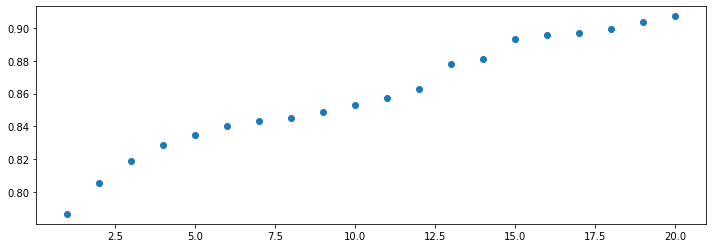

In [101]:
%%time
metric_results = run_n_epochs(model, lr, params, 20)

 21:0.9098  22:0.9118  23:0.9134  24:0.9137  25:0.9153  26:0.9158  27:0.9170  28:0.9184  29:0.9194  30:0.9207
 31:0.9226  32:0.9230  33:0.9234  34:0.9241  35:0.9248  36:0.9252  37:0.9263  38:0.9267  39:0.9271  40:0.9278

Last:0.9278


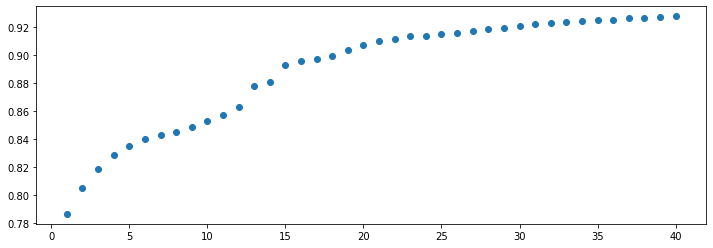

In [102]:
metric_results = run_n_epochs(model, lr, params, 20)

 41:0.9280  42:0.9281  43:0.9286  44:0.9295  45:0.9295  46:0.9302  47:0.9307  48:0.9304  49:0.9301  50:0.9300
 51:0.9308  52:0.9310  53:0.9313  54:0.9312  55:0.9314  56:0.9316  57:0.9320  58:0.9321  59:0.9324  60:0.9335

Last:0.9335


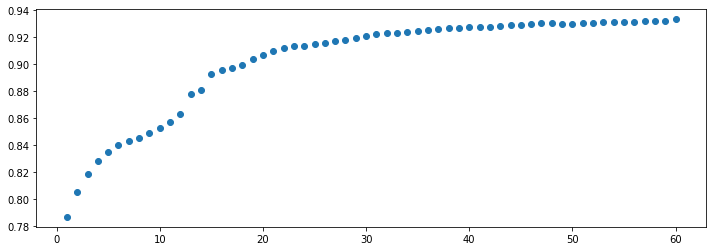

In [103]:
metric_results = run_n_epochs(model, lr, params, 20)

 61:0.9335  62:0.9341  63:0.9349  64:0.9352  65:0.9347  66:0.9347  67:0.9357  68:0.9360  69:0.9365  70:0.9366
 71:0.9364  72:0.9369  73:0.9371  74:0.9373  75:0.9376  76:0.9376  77:0.9378  78:0.9379  79:0.9372  80:0.9376
 81:0.9386  82:0.9383  83:0.9384  84:0.9387  85:0.9388  86:0.9396  87:0.9405  88:0.9405  89:0.9409  90:0.9412
 91:0.9408  92:0.9415  93:0.9413  94:0.9407  95:0.9419  96:0.9418  97:0.9415  98:0.9417  99:0.9421 100:0.9428
101:0.9428 102:0.9428 103:0.9423 104:0.9425 105:0.9430 106:0.9430 107:0.9441 108:0.9442 109:0.9443 110:0.9445

Last:0.9445


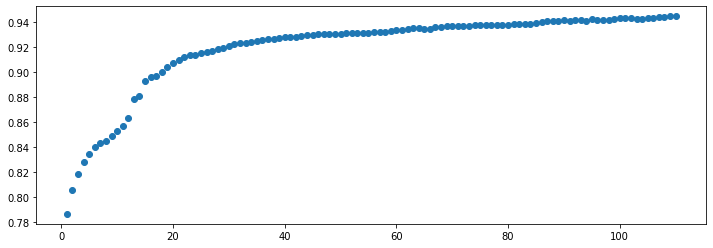

In [104]:
metric_results = run_n_epochs(model, lr, params, 50)

111:0.9442 112:0.9442 113:0.9446 114:0.9444 115:0.9443 116:0.9444 117:0.9448 118:0.9442 119:0.9446 120:0.9448
121:0.9449 122:0.9454 123:0.9452 124:0.9452 125:0.9451 126:0.9452 127:0.9454 128:0.9455 129:0.9456 130:0.9449
131:0.9446 132:0.9450 133:0.9448 134:0.9450 135:0.9450 136:0.9449 137:0.9453 138:0.9455 139:0.9448 140:0.9442
141:0.9446 142:0.9447 143:0.9443 144:0.9446 145:0.9439 146:0.9444 147:0.9449 148:0.9449 149:0.9450 150:0.9445
151:0.9440 152:0.9444 153:0.9440 154:0.9440 155:0.9439 156:0.9438 157:0.9435 158:0.9440 159:0.9437 160:0.9434

Last:0.9434


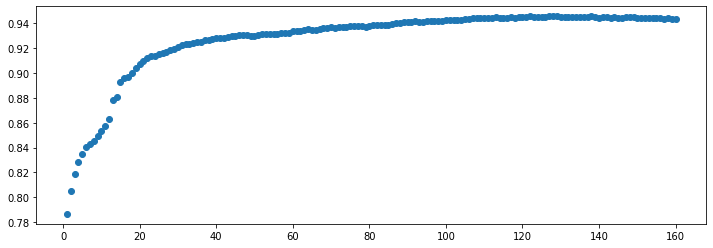

In [105]:
metric_results = run_n_epochs(model, lr, params, 50)

170:0.9433 180:0.9435 190:0.9432 200:0.9432
210:0.9432 220:0.9435 230:0.9440 240:0.9440 250:0.9435 260:0.9437 
Last:0.9437
CPU times: user 36.7 s, sys: 941 ms, total: 37.6 s
Wall time: 37.4 s


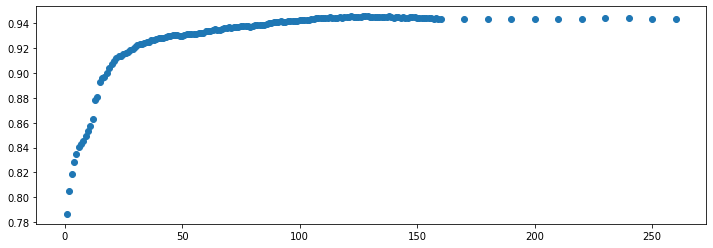

In [106]:
%%time
metric_results = run_n_epochs(model, lr/5, params, 100)

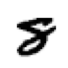

tensor([[8]], device='cuda:0')

In [107]:
img = valid_tensors_dict[8][49]
show_image(img)
plt.show()
classifier(img.view(28*28).unsqueeze(dim=0).to(device))

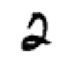

tensor([[2]], device='cuda:0')

In [108]:
img = valid_tensors_dict[2][159]
show_image(img)
plt.show()

classifier(img.view(28*28).unsqueeze(dim=0).to(device))

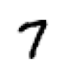

tensor([[7]], device='cuda:0')

In [109]:
img = valid_tensors_dict[7][957]
show_image(img)
plt.show()

classifier(img.view(28*28).unsqueeze(dim=0).to(device))